!git clone https://github.com/ultralytics/yolov5  # clone repo


In [3]:
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

/home/ec2-user/SageMaker/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


!pip install -qr requirements.txt  # install dependencies (ignore errors)


In [4]:
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.1 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qsriDCqyPmufazKUFp0g")
project = rf.workspace("project-ssayl").project("potholes-detection-d4rma")
dataset = project.version(1).download("yolov5")


In [5]:
%cat Potholes-Detection-1/data.yaml

names:
- 'Pothole'
nc: 1
roboflow:
  license: CC BY 4.0
  project: potholes-detection-d4rma
  url: https://universe.roboflow.com/project-ssayl/potholes-detection-d4rma/dataset/1
  version: 1
  workspace: project-ssayl
test: ../test/images
train: Potholes-Detection-1/train/images
val: Potholes-Detection-1/valid/images


In [7]:
import yaml
with open("Potholes-Detection-1/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
import os
HOME = os.getcwd()

In [13]:
{HOME}

{'/home/ec2-user/SageMaker/yolov5'}

In [18]:
%cat /{HOME}/Potholes-Detection-1/data.yaml

names:
- 'Pothole'
nc: 1
roboflow:
  license: CC BY 4.0
  project: potholes-detection-d4rma
  url: https://universe.roboflow.com/project-ssayl/potholes-detection-d4rma/dataset/1
  version: 1
  workspace: project-ssayl
test: ../test/images
train: Potholes-Detection-1/train/images
val: Potholes-Detection-1/valid/images


In [19]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [24]:
%%writetemplate {HOME}/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%%time
%cd {HOME}/
!python train.py --img 416 --batch 16 --epochs 100 --data Potholes-Detection-1/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/home/ec2-user/SageMaker/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=Potholes-Detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 139 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.0.1 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_b

In [29]:
%cd {HOME}

/home/ec2-user/SageMaker/yolov5


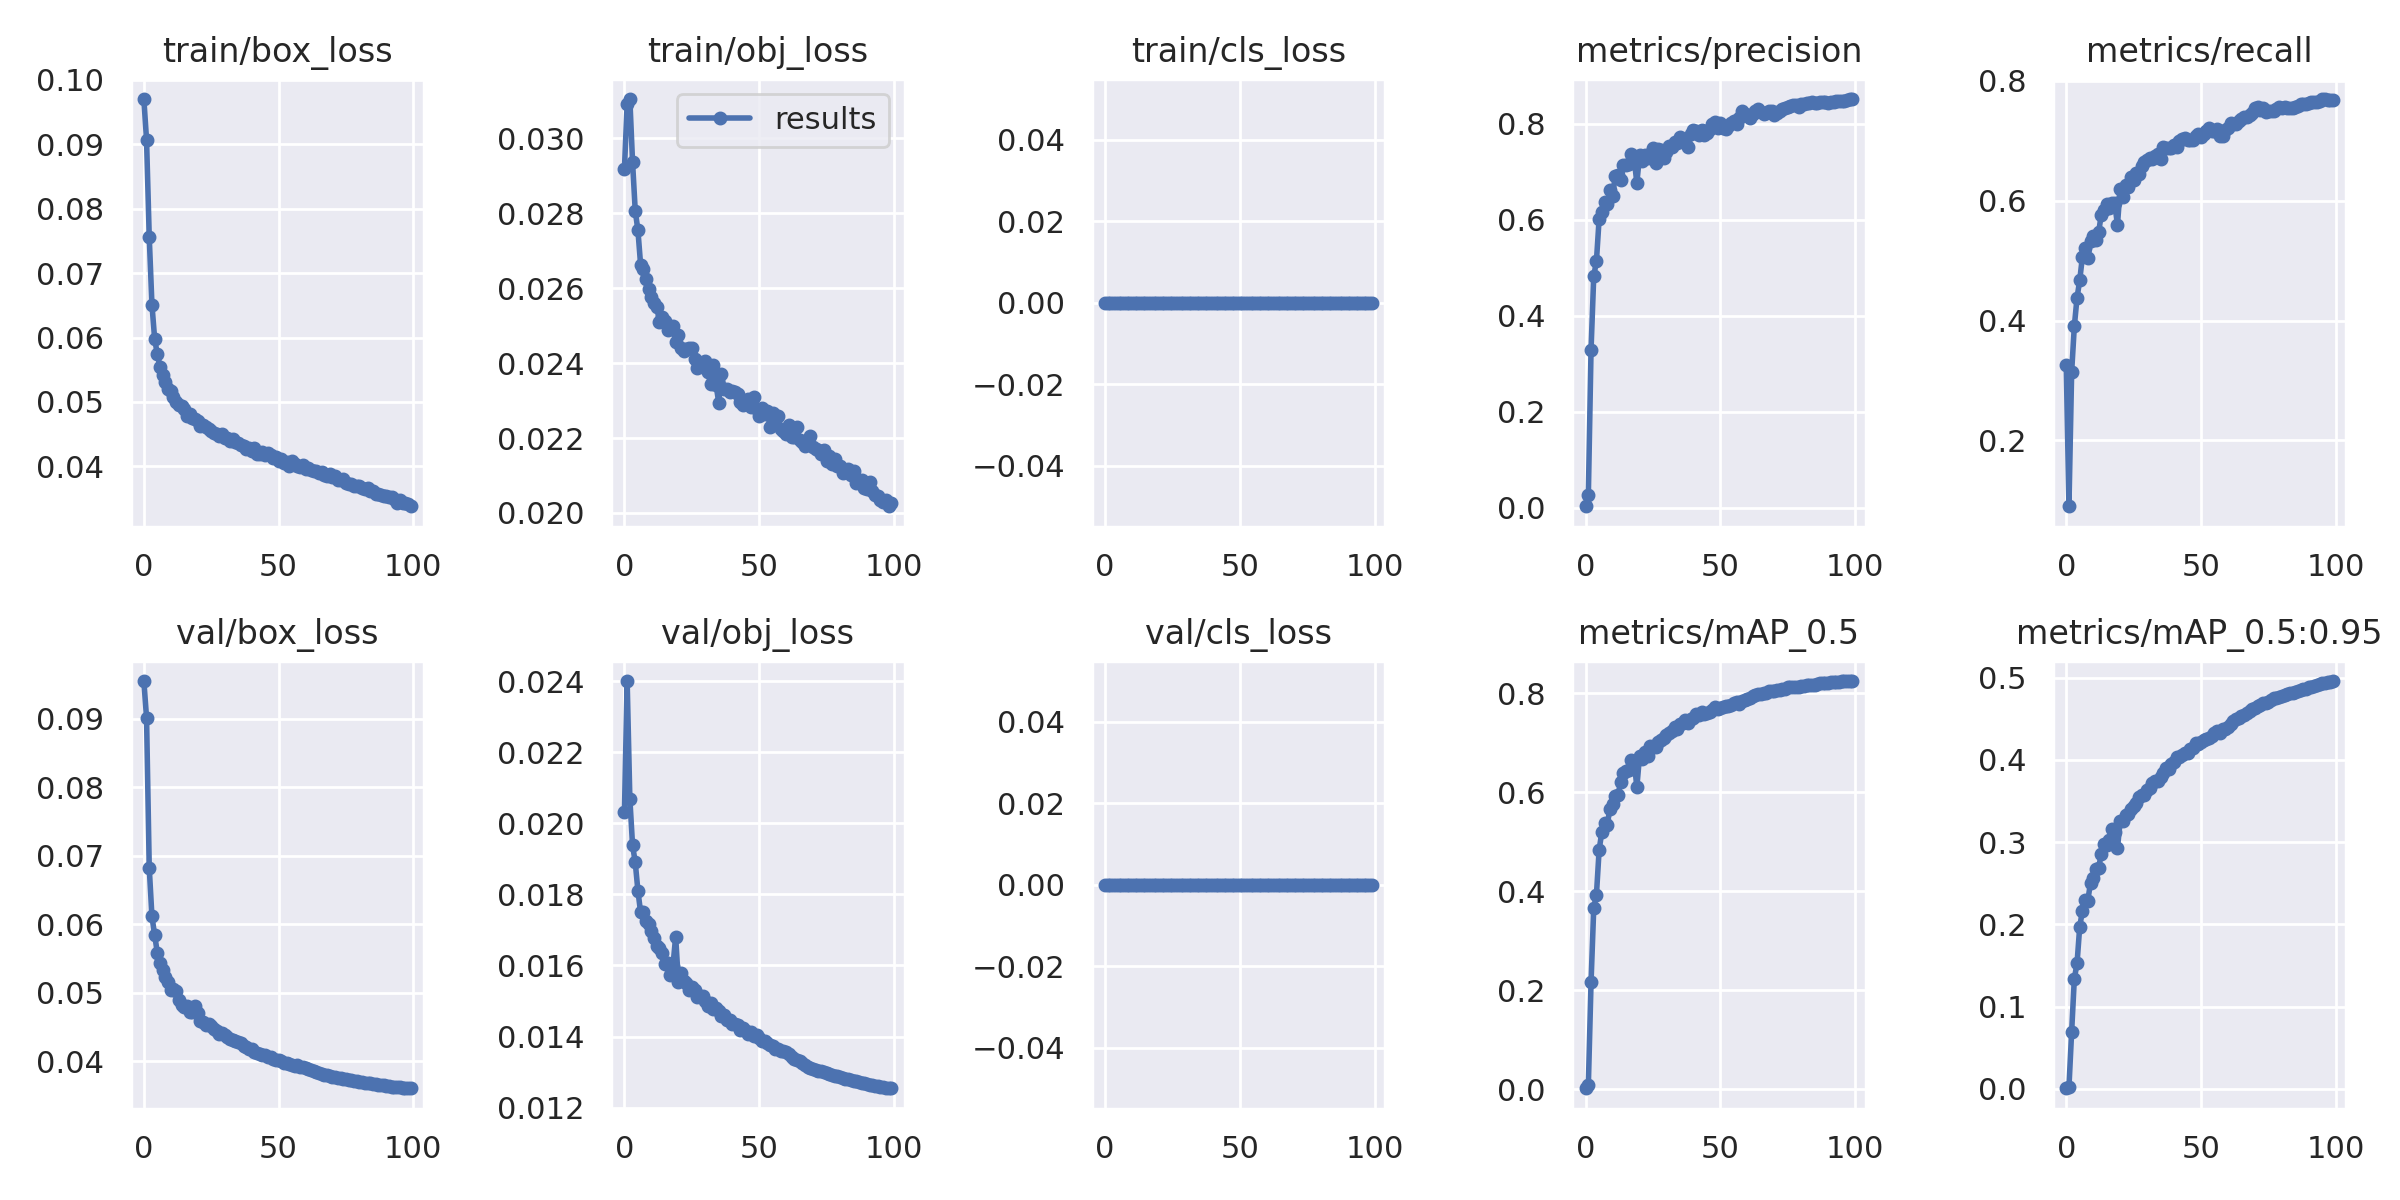

In [31]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename=f'{HOME}/runs/train/yolov5s_results/results.png', width=1000) 

GROUND TRUTH TRAINING DATA:


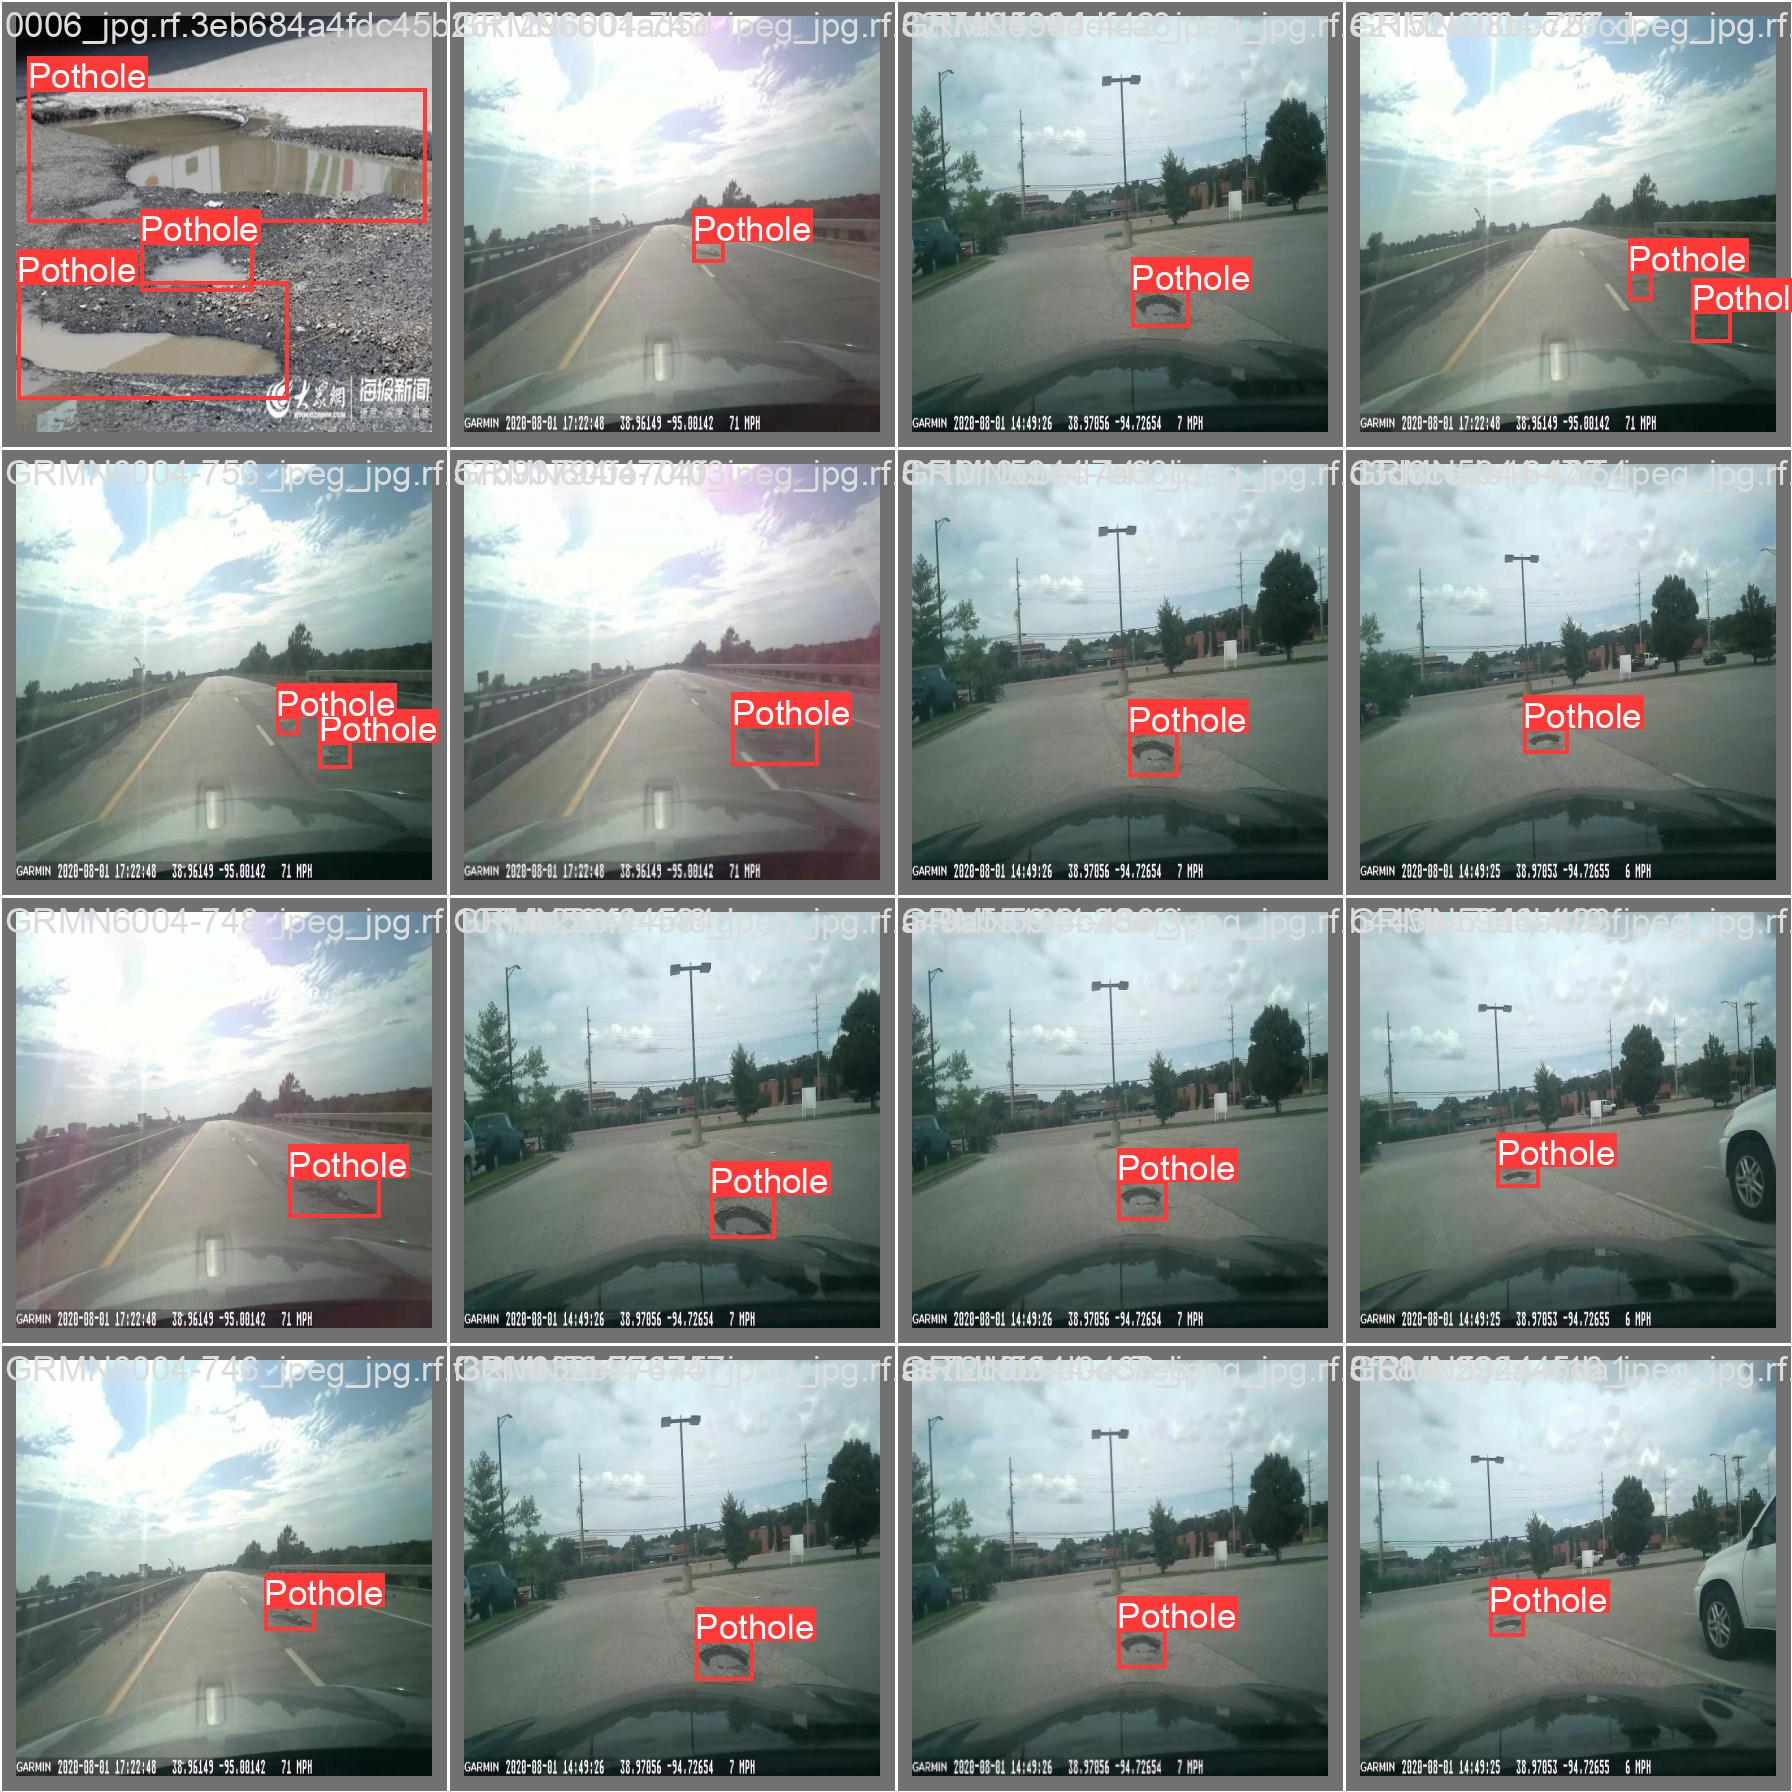

In [33]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename=f'{HOME}/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


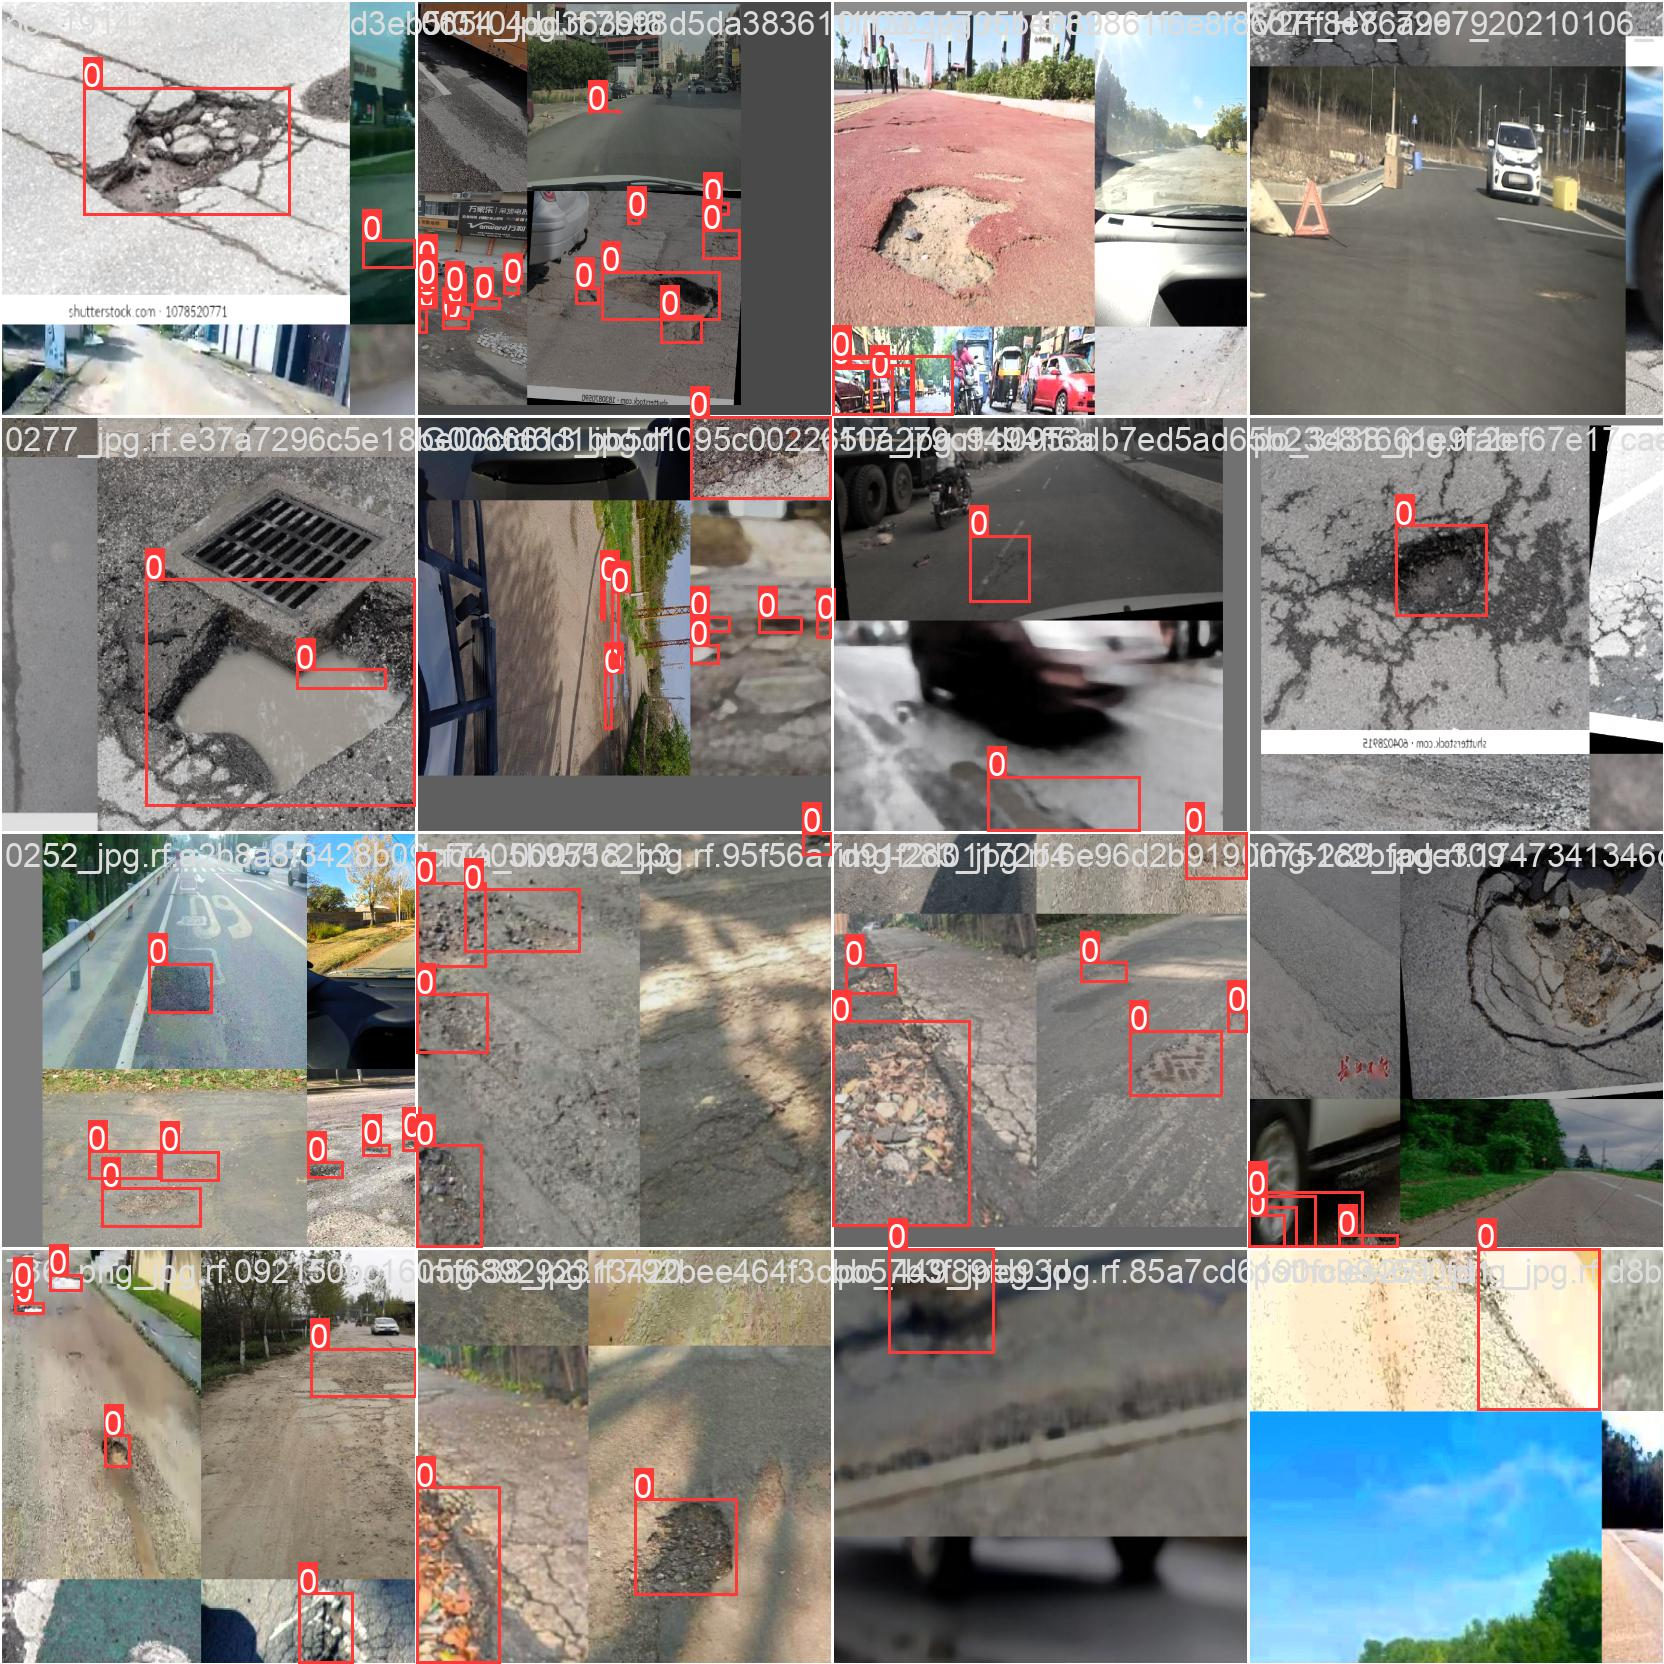

In [34]:
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename=f'{HOME}/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [36]:
%ls runs/

detect/  train/


In [37]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [42]:

!python detect.py --weights {HOME}/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source Potholes-Detection-1/test/images

detect: weights=['/home/ec2-user/SageMaker/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=Potholes-Detection-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.0.1 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
image 1/891 /home/ec2-user/SageMaker/yolov5/Potholes-Detection-1/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg: 416x416 1 Pothole, 5.4ms
image 2/891 /home/ec2-user/SageMaker/yolov5/Potholes-Detection-1/test/images/0040_jpg.rf.ce9dde51c6f4e3fdfb4ad43b0ab1a623.jpg: 416x416 1 Pothole, 5.7